In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.datasets import make_moons
from sklearn import datasets
from sklearn.neighbors import kneighbors_graph
import random
import scipy

In [2]:
n = 1000
n_labeled = 10
alpha = 0.8
sigma = 0.1
gamma=0.001
ratio=40
k=20

In [3]:
X, Y = datasets.make_circles(n_samples=n, shuffle=True, factor=0.5, noise=0.05)

In [4]:
delete_num=n/2-math.floor(n/(ratio+1))-1
print(math.floor(n/(ratio+1)))
print(delete_num)
while delete_num>=0:
  num_element=random.randint(0,n-1)
  if Y[num_element]==1:
    Y=np.delete(Y,num_element)
    X=np.delete(X,num_element,axis=0)
    n=n-1
    delete_num=delete_num-1
print(Y.shape)

24
475.0
(524,)


In [5]:
negative_index=list()
for i in range(len(Y)):
  if Y[i]==1:
    negative_index.append(i)

In [6]:
# here we add our labeled sample to unlabeled sample
Y_input=np.zeros((n,2))
for i in range(math.floor(n_labeled/2)):
   Y_input[negative_index[i],None] = [1,0]
for i in range(n_labeled-math.floor(n_labeled/2)):
   while True:
      j=random.randint(0,len(Y)-1)
      if j not in negative_index:
          Y_input[j,None] = [0,1]
          break

In [8]:
#colorize 2 category that we have and also show sampled label with green
color=list()
for i in range(Y.shape[0]):
  if Y_input[i,0]==0 and Y_input[i,1]==0:
    if Y[i]==0:
      color.append('red')
    elif Y[i]==1:
      color.append('blue')
  if Y_input[i,0]==1:
    color.append('green')
  if Y_input[i,1]==1:
    color.append('yellow')
# color = ['red' if l == 0 else 'blue' for l in Y]

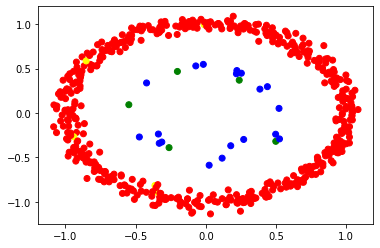

In [9]:
plt.scatter(X[0:,0], X[0:,1], color=color)
plt.savefig("ideal_classification.pdf", format='pdf')
plt.show()

In [10]:
def calculate_w1(X):
  dm = cdist(X, X, 'euclidean')
  rbf = lambda x, sigma: math.exp((-x**2)/(2*(math.pow(sigma,2))))
  vfunc = np.vectorize(rbf)
  W = vfunc(dm, sigma)
  np.fill_diagonal(W, 0)
  return W

In [11]:
def calculate_w2(X):
  dm = cdist(X, X, 'euclidean')
  rbf = lambda x, sigma: math.exp((-x)/(2*(math.pow(sigma,2))))
  vfunc = np.vectorize(rbf)
  W = vfunc(dm, sigma)
  np.fill_diagonal(W, 0)
  return W

In [12]:
W = calculate_w1(X)

In [13]:
A = kneighbors_graph(X, k, mode='connectivity', include_self=True)
A.toarray()
A=scipy.sparse.csr_matrix.toarray(A)
W=np.multiply(W,A)

In [14]:
def calculate_S(W):
    d = np.sum(W, axis=1)
    D = np.sqrt(d*d[:, np.newaxis])
    return np.divide(W,D,where=D!=0)

In [15]:
S = calculate_S(W)

In [16]:
def calculate_D(W):
  d=np.sum(W,axis=1)
  A=np.diag(np.sum(W,axis=1))
  return d,A

In [17]:
d,D=calculate_D(W)

In [18]:
def calculate_P_L(D,W):
  d = np.sum(W, axis=1)
  pi=(d/np.sum(d))
  pi = pi.reshape((1,pi.shape[0]))
  P=np.dot(np.linalg.inv(D),W)
  print("D matrix is : " , D)
  print("inverse of D matrix is : " , np.linalg.inv(D))
  G=np.matmul(np.ones((pi.shape[1] , 1)),pi)
  return P,D-W,G

In [19]:
P,L,G=calculate_P_L(D,W)

D matrix is :  [[10.32293858  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         13.94458301  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         13.13996849 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.82602676  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         13.86892005
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  13.77925989]]
inverse of D matrix is :  [[0.09687164 0.         0.         ... 0.         0.         0.        ]
 [0.         0.07171243 0.         ... 0.         0.         0.        ]
 [0.         0.         0.07610368 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.21061453 0.         0.        ]
 [0.         0.         0.         ... 0.         0.07210367 0.        ]
 [0.         0.         0.         ... 0.         0.         0.07257284]]


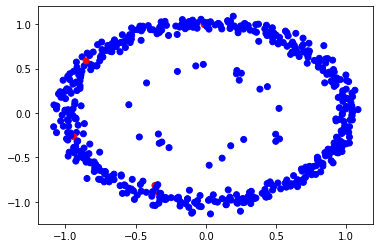

In [20]:
F=np.dot(np.linalg.inv(D),Y_input)

Y_result = np.zeros_like(F)
Y_result[np.arange(len(F)), F.argmax(1)] = 1

Y_v = [1 if x == 1 else 0 for x in Y_result[0:,0]]

color = ['blue' if l == 1 else 'red' for l in Y_v]
plt.scatter(X[0:,0], X[0:,1], color=color)
plt.show()

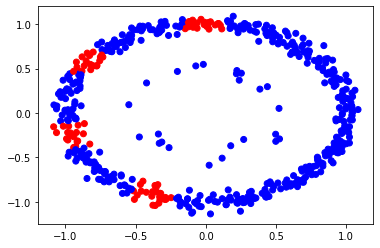

In [21]:
F = np.dot(P, F) +np.dot(G, F)*(-gamma) +np.dot(np.linalg.inv(D),Y_input)*gamma
Y_result = np.zeros_like(F)
Y_result[np.arange(len(F)), F.argmax(1)] = 1

Y_v = [1 if x == 1 else 0 for x in Y_result[0:,0]]

color = ['blue' if l == 1 else 'red' for l in Y_v]

plt.scatter(X[0:,0], X[0:,1], color=color)
plt.show()

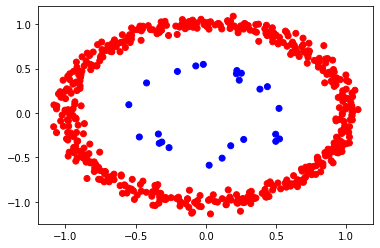

In [22]:
n_iter = 100
third_part = np.dot(np.linalg.inv(D),Y_input)
for t in range(n_iter):
  F = np.dot(P, F) +(-gamma)*np.dot(G, F) +gamma*third_part

Y_result = np.zeros_like(F)
Y_result[np.arange(len(F)), F.argmax(1)] = 1

Y_v = [1 if x == 1 else 0 for x in Y_result[0:,0]]

color = ['blue' if l == 1 else 'red' for l in Y_v]
plt.scatter(X[0:,0], X[0:,1], color=color)
plt.show()

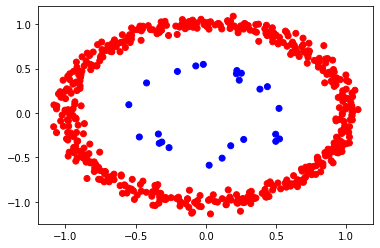

In [23]:
n_iter = 500
third_part = np.dot(np.linalg.inv(D),Y_input)
for t in range(n_iter):
    F = np.dot(P, F) +(-gamma)*np.dot(G, F) +gamma*third_part

Y_result = np.zeros_like(F)
Y_result[np.arange(len(F)), F.argmax(1)] = 1

Y_v = [1 if x == 1 else 0 for x in Y_result[0:,0]]

color = ['blue' if l == 1 else 'red' for l in Y_v]
plt.scatter(X[0:,0], X[0:,1], color=color)
plt.show()

In [24]:
from sklearn.metrics import accuracy_score
y_true_ours=[Y[i] for i in range(Y.shape[0])]
y_predict_ours=[1 if (Y_result[i]==np.array([1,0])).all() else 0 for i in range(Y.shape[0])]    
accuracy_score(y_true_ours, y_predict_ours)

1.0